In [22]:
# Standard imports for TDA
import yfinance as yf
import numpy as np
import pandas as pd
from ripser import Rips
import persim
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [23]:
# Define a list of tickers
# tickers = ['^GSPC']
# tickers = ['^GSPC', '^DJI', '^IXIC', '^RUT']

### Fetch data from Yahoo Finance

* Data is taken from 1st January 2006 to 1st January 2014.
* The Closing prices for daily returns were taken.
* Stock taken is the Dow Jones Index.

In [24]:
# Set the end date to today
# end_date = datetime.today()
end_date = '2014-01-01'

In [25]:
# Set the start date from 2 years ago
# start_date = end_date - timedelta(days=2*365)
# print(start_date)
start_date = '2006-01-01'

In [26]:
# Pull data into a empty dataframe
df = pd.DataFrame()

# for ticker in tickers:
#     raw_data = yf.download(ticker, start=start_date, end=end_date)
#     df = raw_data

SP500 = yf.Ticker("^DJI")
raw_data = SP500.history(period="max", start=start_date, end=end_date)
df = raw_data

In [27]:
# Checking to see if there is any missing data
df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [28]:
# Fetching only close price
df_close = df['Close'] # Becease adj. close price considers other factors like dividends, stock splits and new stock offering.
print(len(df_close))
df_close = df_close.to_frame()
df_close

2013


,Close
Date,
2006-01-03 00:00:00-05:00,10847.410156
2006-01-04 00:00:00-05:00,10880.150391
2006-01-05 00:00:00-05:00,10882.150391
2006-01-06 00:00:00-05:00,10959.309570
2006-01-09 00:00:00-05:00,11011.900391
...,...
2013-12-24 00:00:00-05:00,16357.549805
2013-12-26 00:00:00-05:00,16479.880859
2013-12-27 00:00:00-05:00,16478.410156


### Prepare data cloud

* Convert dataframe to numpy array.
* Compute the Log daily return of each index.

In [29]:
# Define array of adjusted closing prices
P = df_close.to_numpy()
# Define array of log-returns defined as the log of the ratio between closing values of two subsequent days
r = np.log(np.divide(P[1:],P[:len(P)-1]))

### Track changes in the shape of the market by looking at how the homology of the market changes over time

* Initilize the object that constructs simplicial complexes from data.
* Define a time window size which will allow us to grab a chuck of data to analyse the homology (Here w = 20).
* Define the total number of the chucks we will have.
* Create a numpy array that keeps track of the number that quantifies changes in homology. 

In [30]:
# Instantiate Vietoris-Rips solver
rips = Rips(maxdim=2)

# some parameters
w = 20 # time window size
n = len(raw_data)-(2*w)+1 # number of time segments
wasserstein_dists = np.zeros((n,1)) # initialize array for wasserstein distances

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


### Conducting Persistent Homology

* Take the first 20 rows of data and the next set of 20 rows of data to do persistent homology.
* The `fit_transform` method is used to create four-dimensional balls around each point where each choice of radius creates a simplicial complex and the method track the holes that appear and disappear using a persistent diagram.
* Next we quantified the overall homology between the two persistent diagrams (`dmg1` and `dmg2`) using the Wasserstein distance (a distance measure between two persistent diagrams).
* We repeat this process for all the row of the data set.

In [ ]:
# compute wasserstein distances between persitence diagrams for subsequent time windows
for i in range(n):
    # Compute persistence diagrams for adjacent time windows
    dgm1 = rips.fit_transform(r[i:i+w])
    dgm2 = rips.fit_transform(r[i+w+1:i+(2*w)+1])
    # Compute wasserstein distance between diagrams
    wasserstein_dists[i] = persim.wasserstein(dgm1[0], dgm2[0], matching=False)

### Plot the time series which show the quantification of consective days that the market was open.

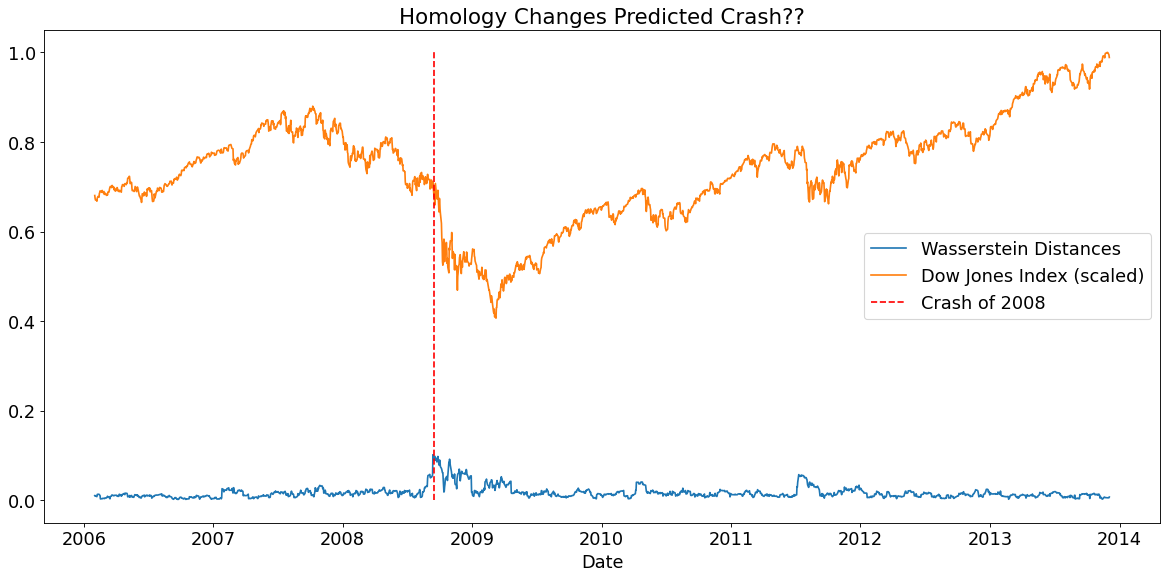

In [31]:
# Plot wasserstein distances over time
plt.figure(figsize=(18, 8), dpi=80)
plt.rcParams.update({'font.size': 16})

plt.plot(raw_data.index[w:n+w], wasserstein_dists)
plt.plot(raw_data.index[w:n+w], df_close.iloc[w:n+w,0]/max(df_close.iloc[w:n+w,0]))
# plt.plot([raw_data.index[501], raw_data.index[501]], [0, 1], 'r--')
plt.plot([raw_data.index[679], raw_data.index[679]], [0, 1], 'r--')
plt.legend(['Wasserstein Distances', 'Dow Jones Index (scaled)', 'Crash of 2008'])
plt.xlabel('Date')
plt.title('Homology Changes Predicted Crash??')
plt.show()

# plt.savefig('Homology_example.png', dpi='figure', format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')